In [1]:
#Libraries

# ignore warnings
import warnings
warnings.filterwarnings("ignore")

# Wrangling
import pandas as pd
import numpy as np

# preparing
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, explained_variance_score

# modeling and evaluating
from sklearn.linear_model import LinearRegression, LassoLars
from sklearn.linear_model import TweedieRegressor
from sklearn.feature_selection import RFE
from sklearn.feature_selection import SelectKBest, f_regression
from sklearn.model_selection import learning_curve
from sklearn.preprocessing import PolynomialFeatures
from sklearn.preprocessing import MinMaxScaler, RobustScaler, StandardScaler
from sklearn.preprocessing import PolynomialFeatures
from sklearn.cluster import KMeans

# Exploring
import scipy.stats as stats
import math

# Visualizing
import matplotlib.pyplot as plt
from matplotlib import cm
import seaborn as sns

%matplotlib inline

# Add more libraries below this line as needed.

In [2]:
import os
import env
import acquire
import wrangle
import wrangle_zillow_new

credentials loaded successfully
End of file.
Loaded zillow wrangle functions successfully.
Imported prepare.py successfully


# Acquire

In [3]:
df = wrangle.get_zillow_data()
df.shape

(77381, 70)

In [4]:
df.head()

,parcelid,typeconstructiontypeid,storytypeid,propertylandusetypeid,heatingorsystemtypeid,buildingclasstypeid,architecturalstyletypeid,airconditioningtypeid,id,basementsqft,...,logerror,pid,tdate,airconditioningdesc,architecturalstyledesc,buildingclassdesc,heatingorsystemdesc,propertylandusedesc,storydesc,typeconstructiondesc
0,14297519,NaN,NaN,261.0,NaN,NaN,NaN,NaN,1727539,NaN,...,0.025595,14297519,2017-01-01,NaN,NaN,NaN,NaN,Single Family Residential,NaN,NaN
1,17052889,NaN,NaN,261.0,NaN,NaN,NaN,NaN,1387261,NaN,...,0.055619,17052889,2017-01-01,NaN,NaN,NaN,NaN,Single Family Residential,NaN,NaN
2,14186244,NaN,NaN,261.0,NaN,NaN,NaN,NaN,11677,NaN,...,0.005383,14186244,2017-01-01,NaN,NaN,NaN,NaN,Single Family Residential,NaN,NaN
3,12177905,NaN,NaN,261.0,2.0,NaN,NaN,NaN,2288172,NaN,...,-0.103410,12177905,2017-01-01,NaN,NaN,NaN,Central,Single Family Residential,NaN,NaN
4,10887214,NaN,NaN,266.0,2.0,NaN,NaN,1.0,1970746,NaN,...,0.006940,10887214,2017-01-01,Central,NaN,NaN,Central,Condominium,NaN,NaN


In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 77381 entries, 0 to 77380
Data columns (total 70 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   parcelid                      77381 non-null  int64  
 1   typeconstructiontypeid        222 non-null    float64
 2   storytypeid                   50 non-null     float64
 3   propertylandusetypeid         77381 non-null  float64
 4   heatingorsystemtypeid         49440 non-null  float64
 5   buildingclasstypeid           15 non-null     float64
 6   architecturalstyletypeid      206 non-null    float64
 7   airconditioningtypeid         24953 non-null  float64
 8   id                            77381 non-null  int64  
 9   basementsqft                  50 non-null     float64
 10  bathroomcnt                   77381 non-null  float64
 11  bedroomcnt                    77381 non-null  float64
 12  buildingqualitytypeid         49672 non-null  float64
 13  c

In [6]:
df.describe()

,parcelid,typeconstructiontypeid,storytypeid,propertylandusetypeid,heatingorsystemtypeid,buildingclasstypeid,architecturalstyletypeid,airconditioningtypeid,id,basementsqft,...,structuretaxvaluedollarcnt,taxvaluedollarcnt,assessmentyear,landtaxvaluedollarcnt,taxamount,taxdelinquencyyear,censustractandblock,id.1,logerror,pid
count,7.738100e+04,222.000000,50.0,77381.000000,49440.000000,15.000000,206.000000,24953.000000,7.738100e+04,50.000000,...,7.726900e+04,7.738000e+04,77381.0,7.737900e+04,77376.000000,2886.000000,7.713700e+04,77381.000000,77381.000000,7.738100e+04
mean,1.300715e+07,6.040541,7.0,261.826340,3.920510,3.933333,7.388350,1.813289,1.495139e+06,679.720000,...,1.893145e+05,4.901345e+05,2016.0,3.010954e+05,5995.532346,14.087318,6.049673e+13,38848.692754,0.016625,1.300715e+07
std,3.481346e+06,0.557285,0.0,5.141199,3.592779,0.258199,2.734542,2.967894,8.609071e+05,689.703546,...,2.300874e+05,6.534440e+05,0.0,4.925960e+05,7622.844153,2.185663,1.535242e+12,22402.429065,0.170191,3.481346e+06
min,1.071186e+07,4.000000,7.0,31.000000,1.000000,3.000000,2.000000,1.000000,3.490000e+02,38.000000,...,4.400000e+01,1.000000e+03,2016.0,1.610000e+02,19.920000,3.000000,6.037101e+13,0.000000,-4.655420,1.071186e+07
25%,1.153830e+07,6.000000,7.0,261.000000,2.000000,4.000000,7.000000,1.000000,7.520700e+05,273.000000,...,8.426500e+04,2.070000e+05,2016.0,8.550400e+04,2715.632500,14.000000,6.037311e+13,19461.000000,-0.024377,1.153830e+07
50%,1.253157e+07,6.000000,7.0,261.000000,2.000000,4.000000,7.000000,1.000000,1.497932e+06,515.000000,...,1.364990e+05,3.589755e+05,2016.0,2.033720e+05,4450.695000,15.000000,6.037603e+13,38870.000000,0.006627,1.253157e+07
75%,1.421183e+07,6.000000,7.0,266.000000,7.000000,4.000000,7.000000,1.000000,2.240535e+06,796.500000,...,2.187870e+05,5.690015e+05,2016.0,3.667965e+05,6927.790000,15.000000,6.059042e+13,58253.000000,0.039203,1.421183e+07
max,1.676893e+08,13.000000,7.0,275.000000,24.000000,4.000000,21.000000,13.000000,2.982274e+06,3560.000000,...,1.142179e+07,4.906124e+07,2016.0,4.895220e+07,586639.300000,99.000000,4.830301e+14,77613.000000,5.262999,1.676893e+08


# Prep

### First step, remove columns that I know I won't be needing

A lot of missing values, however I will remove the columns I don't think I'll be needing first, then address missing rows.

In [7]:
# Dropping columns I don't think I'll need. If I do end up needing them, come back to this point after the MVP is done.

df = wrangle.drop_cols(df)
df.shape

(77381, 50)

In [8]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 77381 entries, 0 to 77380
Data columns (total 50 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   typeconstructiontypeid        222 non-null    float64
 1   storytypeid                   50 non-null     float64
 2   propertylandusetypeid         77381 non-null  float64
 3   buildingclasstypeid           15 non-null     float64
 4   architecturalstyletypeid      206 non-null    float64
 5   airconditioningtypeid         24953 non-null  float64
 6   basementsqft                  50 non-null     float64
 7   bathroomcnt                   77381 non-null  float64
 8   bedroomcnt                    77381 non-null  float64
 9   decktypeid                    614 non-null    float64
 10  finishedfloor1squarefeet      6023 non-null   float64
 11  calculatedfinishedsquarefeet  77185 non-null  float64
 12  finishedsquarefeet13          41 non-null     float64
 13  f

In [9]:
# I need to isolate down to only single unit properties, which equate to this list:

id_list = [261.0, 260.0, 262.0, 263.0, 264.0]

In [10]:
# Now I have 20k less rows, so good for the most part. Now need to cut down the columns:

df = wrangle.prep_data(df, id_list)
df.shape

(52244, 50)

In [11]:
df = wrangle.handle_missing_values(df, col_limit = .6, row_limit = .6)
df.shape

(52244, 16)

In [12]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 52244 entries, 0 to 77380
Data columns (total 16 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   propertylandusetypeid         52244 non-null  float64
 1   bathroomcnt                   52244 non-null  float64
 2   bedroomcnt                    52244 non-null  float64
 3   calculatedfinishedsquarefeet  52236 non-null  float64
 4   fips                          52244 non-null  float64
 5   latitude                      52244 non-null  float64
 6   longitude                     52244 non-null  float64
 7   lotsizesquarefeet             51883 non-null  float64
 8   regionidcity                  51216 non-null  float64
 9   roomcnt                       52244 non-null  float64
 10  yearbuilt                     52204 non-null  float64
 11  structuretaxvaluedollarcnt    52172 non-null  float64
 12  taxvaluedollarcnt             52243 non-null  float64
 13  l

In [13]:
# I don't need this column any more.
df.drop(columns = ['propertylandusetypeid'], inplace = True)


In [14]:
df.isna().sum().sort_values(ascending = False)

regionidcity                    1028
lotsizesquarefeet                361
structuretaxvaluedollarcnt        72
yearbuilt                         40
calculatedfinishedsquarefeet       8
taxamount                          4
landtaxvaluedollarcnt              1
taxvaluedollarcnt                  1
logerror                           0
roomcnt                            0
longitude                          0
latitude                           0
fips                               0
bedroomcnt                         0
bathroomcnt                        0
dtype: int64

In [15]:
df = df.dropna()
df.isna().sum().sort_values(ascending = False)

logerror                        0
taxamount                       0
landtaxvaluedollarcnt           0
taxvaluedollarcnt               0
structuretaxvaluedollarcnt      0
yearbuilt                       0
roomcnt                         0
regionidcity                    0
lotsizesquarefeet               0
longitude                       0
latitude                        0
fips                            0
calculatedfinishedsquarefeet    0
bedroomcnt                      0
bathroomcnt                     0
dtype: int64

## Things on my mind:

- Will clustering be beneficial to my understanding of the data and relationships
- Are there new features I can create from my current feature list that will do a better job of predicting `logerror`?

In [16]:
pd.set_option('display.max_columns', 40)

# Adding new dummy columns:

county_df = pd.get_dummies(df.fips)
county_df.head(1)

county_df.columns = ["LA", "Orange", "Ventura"]
# df_dummies = pd.concat([df, county_df], axis = 1)
df = pd.concat([df, county_df], axis = 1)
print(df.shape)
df.head(1)

(50800, 18)


,bathroomcnt,bedroomcnt,calculatedfinishedsquarefeet,fips,latitude,longitude,lotsizesquarefeet,regionidcity,roomcnt,yearbuilt,structuretaxvaluedollarcnt,taxvaluedollarcnt,landtaxvaluedollarcnt,taxamount,logerror,LA,Orange,Ventura
0,3.5,4.0,3100.0,6059.0,33.634931,-117.869207,4506.0,53571.0,0.0,1998.0,485713.0,1023282.0,537569.0,11013.72,0.025595,0,1,0


In [17]:
# adding features:

def create_features(df):
    df['age'] = 2017 - df.yearbuilt

    # create taxrate variable
    df['taxrate'] = df.taxamount/df.taxvaluedollarcnt
    
    # create acres variable
    df['acres'] = df.lotsizesquarefeet/43560
    
    # dollar per square foot-structure
    df['structure_dollar_per_sqft'] = df.structuretaxvaluedollarcnt/df.calculatedfinishedsquarefeet

    # dollar per square foot-land
    df['land_dollar_per_sqft'] = df.landtaxvaluedollarcnt/df.lotsizesquarefeet
    
    # ratio of beds to baths
    df['bed_bath_ratio'] = df.bedroomcnt/df.bathroomcnt
    
    
    
    return df

In [18]:
df = create_features(df)

<AxesSubplot:xlabel='structure_dollar_per_sqft', ylabel='fips'>

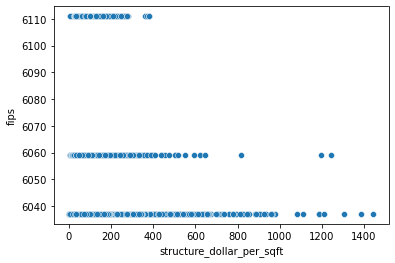

In [19]:
sns.scatterplot(x = 'structure_dollar_per_sqft', y = 'fips', data = df)

# Note there are only about 8 outliers that are making the 4th quartile to the max value extremely large compared to the rest of the quartiles.
# These kind of outliers will greatly affect the clustering models. Need to remove them.

In [20]:
# Need to remove outliers because outliers have a very large negative impact on clustering.

def remove_outliers():
    '''
    remove outliers in in structure dollars and land dollars.
    '''

    return df[((df.bathroomcnt <= 7) & (df.bedroomcnt <= 7) &  
               (df.bathroomcnt > 0) & 
               (df.bedroomcnt > 0) & 
               (df.acres < 10) &
               (df.calculatedfinishedsquarefeet < 7000) & 
               (df.taxrate < .05) &
               (df.structure_dollar_per_sqft < 1001) &
               (df.land_dollar_per_sqft < 1501)
              )]

<AxesSubplot:xlabel='structure_dollar_per_sqft', ylabel='fips'>

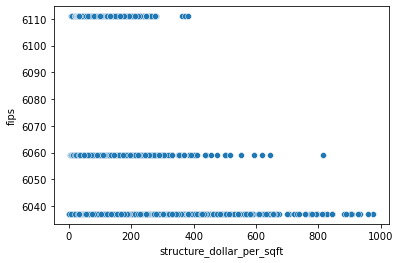

In [21]:
df = remove_outliers()
sns.scatterplot(x = 'structure_dollar_per_sqft', y = 'fips', data = df)

<AxesSubplot:xlabel='land_dollar_per_sqft', ylabel='structure_dollar_per_sqft'>

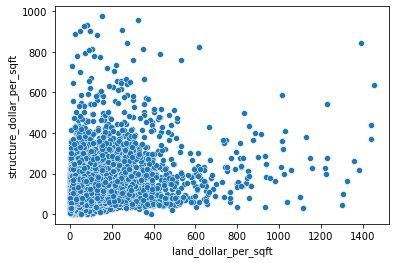

In [22]:
sns.scatterplot(x = 'land_dollar_per_sqft', y = 'structure_dollar_per_sqft', data = df)

In [23]:
df.isnull().sum().sort_values(ascending = False)

bed_bath_ratio                  0
land_dollar_per_sqft            0
bedroomcnt                      0
calculatedfinishedsquarefeet    0
fips                            0
latitude                        0
longitude                       0
lotsizesquarefeet               0
regionidcity                    0
roomcnt                         0
yearbuilt                       0
structuretaxvaluedollarcnt      0
taxvaluedollarcnt               0
landtaxvaluedollarcnt           0
taxamount                       0
logerror                        0
LA                              0
Orange                          0
Ventura                         0
age                             0
taxrate                         0
acres                           0
structure_dollar_per_sqft       0
bathroomcnt                     0
dtype: int64

In [24]:
df_la = df[df.LA == 1].drop(columns = ['Orange', 'Ventura'])
df_la.shape

(32509, 22)

In [25]:
df_o = df[df.Orange == 1].drop(columns = ['LA', 'Ventura'])
df_v = df[df.Ventura == 1].drop(columns = ['Orange', 'LA'])
df_o.shape, df_v.shape

((13623, 22), (4309, 22))

In [26]:
df_la.head(1)

,bathroomcnt,bedroomcnt,calculatedfinishedsquarefeet,fips,latitude,longitude,lotsizesquarefeet,regionidcity,roomcnt,yearbuilt,structuretaxvaluedollarcnt,taxvaluedollarcnt,landtaxvaluedollarcnt,taxamount,logerror,LA,age,taxrate,acres,structure_dollar_per_sqft,land_dollar_per_sqft,bed_bath_ratio
3,3.0,4.0,2376.0,6037.0,34.24518,-118.240722,13038.0,396551.0,0.0,1970.0,108918.0,145143.0,36225.0,1777.51,-0.10341,1,47.0,0.012247,0.299311,45.840909,2.778417,1.333333


In [27]:
# Checking to see the count of fips in each new county df. Making sure there wasn't any leakage between them.

df_la.fips.value_counts(), df_o.fips.value_counts(), df_v.fips.value_counts(),

(6037.0    32509
 Name: fips, dtype: int64,
 6059.0    13623
 Name: fips, dtype: int64,
 6111.0    4309
 Name: fips, dtype: int64)

At this point, I'd want to do everything in triplets, but I think that'll take too long so I'm going to continue using the main dataframe and just add a county column so that I can still divide things by county.

I'll end up with 3 dataframes per county df, which means a total of 9 dataframes... That seems like a bit much, at least for an MVP.

In [28]:
# I no longer need this column:

# df = df.drop(columns = "propertylandusetypeid")
# df.drop(columns = ['regionidcity', 'regionidcounty', 'unitcnt'], inplace = True)
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 50441 entries, 0 to 77380
Data columns (total 24 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   bathroomcnt                   50441 non-null  float64
 1   bedroomcnt                    50441 non-null  float64
 2   calculatedfinishedsquarefeet  50441 non-null  float64
 3   fips                          50441 non-null  float64
 4   latitude                      50441 non-null  float64
 5   longitude                     50441 non-null  float64
 6   lotsizesquarefeet             50441 non-null  float64
 7   regionidcity                  50441 non-null  float64
 8   roomcnt                       50441 non-null  float64
 9   yearbuilt                     50441 non-null  float64
 10  structuretaxvaluedollarcnt    50441 non-null  float64
 11  taxvaluedollarcnt             50441 non-null  float64
 12  landtaxvaluedollarcnt         50441 non-null  float64
 13  t

In [29]:
df.head()

,bathroomcnt,bedroomcnt,calculatedfinishedsquarefeet,fips,latitude,longitude,lotsizesquarefeet,regionidcity,roomcnt,yearbuilt,structuretaxvaluedollarcnt,taxvaluedollarcnt,landtaxvaluedollarcnt,taxamount,logerror,LA,Orange,Ventura,age,taxrate,acres,structure_dollar_per_sqft,land_dollar_per_sqft,bed_bath_ratio
0,3.5,4.0,3100.0,6059.0,33.634931,-117.869207,4506.0,53571.0,0.0,1998.0,485713.0,1023282.0,537569.0,11013.72,0.025595,0,1,0,19.0,0.010763,0.103444,156.681613,119.300710,1.142857
1,1.0,2.0,1465.0,6111.0,34.449266,-119.281531,12647.0,13091.0,5.0,1967.0,88000.0,464000.0,376000.0,5672.48,0.055619,0,0,1,50.0,0.012225,0.290335,60.068259,29.730371,2.000000
2,2.0,3.0,1243.0,6059.0,33.886168,-117.823170,8432.0,21412.0,6.0,1962.0,85289.0,564778.0,479489.0,6488.30,0.005383,0,1,0,55.0,0.011488,0.193572,68.615447,56.865394,1.500000
3,3.0,4.0,2376.0,6037.0,34.245180,-118.240722,13038.0,396551.0,0.0,1970.0,108918.0,145143.0,36225.0,1777.51,-0.103410,1,0,0,47.0,0.012247,0.299311,45.840909,2.778417,1.333333
6,3.0,4.0,2962.0,6037.0,34.145202,-118.179824,63000.0,47019.0,0.0,1950.0,276684.0,773303.0,496619.0,9516.26,-0.001011,1,0,0,67.0,0.012306,1.446281,93.411209,7.882841,1.333333


## Splitting Data

In [30]:
train, validate, test = wrangle.split_zillow_data(df)

Shape of train df: (34299, 24)
Shape of validate df: (8575, 24)
Shape of test df: (7567, 24)


In [31]:
# Impute missing values
train.isna().sum().sort_values(ascending = False)

bed_bath_ratio                  0
land_dollar_per_sqft            0
bedroomcnt                      0
calculatedfinishedsquarefeet    0
fips                            0
latitude                        0
longitude                       0
lotsizesquarefeet               0
regionidcity                    0
roomcnt                         0
yearbuilt                       0
structuretaxvaluedollarcnt      0
taxvaluedollarcnt               0
landtaxvaluedollarcnt           0
taxamount                       0
logerror                        0
LA                              0
Orange                          0
Ventura                         0
age                             0
taxrate                         0
acres                           0
structure_dollar_per_sqft       0
bathroomcnt                     0
dtype: int64

In [ ]:
# No need to run this since there are no missing values...

train, validate, test = wrangle.impute_missing_values_all(train, validate, test)
train.head()

# Don't forget to .cut() in this area
# bin by age of house, county, tax bracket, and sq footage for starters

In [32]:
def split(df, target_var):
    # split df into train_validate (80%) and test (20%)
    train_validate, test = train_test_split(df, test_size=.20, random_state=13)
    # split train_validate into train(70% of 80% = 56%) and validate (30% of 80% = 24%)
    train, validate = train_test_split(train_validate, test_size=.3, random_state=13)
    
    # create X_train by dropping the target variable 
    X_train = train.drop(columns=[target_var])
    # create y_train by keeping only the target variable.
    y_train = train[[target_var]]

    # create X_validate by dropping the target variable 
    X_validate = validate.drop(columns=[target_var])
    # create y_validate by keeping only the target variable.
    y_validate = validate[[target_var]]

    # create X_test by dropping the target variable 
    X_test = test.drop(columns=[target_var])
    # create y_test by keeping only the target variable.
    y_test = test[[target_var]]
    
    return X_train, y_train, X_validate, y_validate, X_test, y_test

In [33]:
def split_new(train, validate, test, target_var):
#     # split df into train_validate (80%) and test (20%)
#     train_validate, test = train_test_split(df, test_size=.20, random_state=13)
#     # split train_validate into train(70% of 80% = 56%) and validate (30% of 80% = 24%)
#     train, validate = train_test_split(train_validate, test_size=.3, random_state=13)
    
    # create X_train by dropping the target variable 
    X_train = train.drop(columns=[target_var])
    # create y_train by keeping only the target variable.
    y_train = train[[target_var]]

    # create X_validate by dropping the target variable 
    X_validate = validate.drop(columns=[target_var])
    # create y_validate by keeping only the target variable.
    y_validate = validate[[target_var]]

    # create X_test by dropping the target variable 
    X_test = test.drop(columns=[target_var])
    # create y_test by keeping only the target variable.
    y_test = test[[target_var]]
    
    return X_train, y_train, X_validate, y_validate, X_test, y_test

In [34]:
X_train, y_train, X_validate, y_validate, X_test, y_test = split(df, 'logerror')
X_train.shape, X_validate.shape, X_test.shape

((28246, 23), (12106, 23), (10089, 23))

In [35]:
X_train.head()

,bathroomcnt,bedroomcnt,calculatedfinishedsquarefeet,fips,latitude,longitude,lotsizesquarefeet,regionidcity,roomcnt,yearbuilt,structuretaxvaluedollarcnt,taxvaluedollarcnt,landtaxvaluedollarcnt,taxamount,LA,Orange,Ventura,age,taxrate,acres,structure_dollar_per_sqft,land_dollar_per_sqft,bed_bath_ratio
4433,2.0,3.0,1440.0,6037.0,33.983095,-118.327213,4038.0,12447.0,0.0,1938.0,110472.0,286062.0,175590.0,6093.88,1,0,0,79.0,0.021303,0.092700,76.716667,43.484398,1.5
50384,1.0,2.0,1030.0,6037.0,34.142901,-118.104895,6872.0,47019.0,0.0,1924.0,97834.0,489177.0,391343.0,5790.64,1,0,0,93.0,0.011838,0.157759,94.984466,56.947468,2.0
17915,1.0,3.0,1319.0,6037.0,33.970589,-118.325048,6713.0,45888.0,0.0,1923.0,24621.0,44062.0,19441.0,862.20,1,0,0,94.0,0.019568,0.154109,18.666414,2.896023,3.0
53177,2.0,3.0,1626.0,6037.0,34.124369,-117.714644,13566.0,30908.0,0.0,1977.0,106851.0,132210.0,25359.0,2076.85,1,0,0,40.0,0.015709,0.311433,65.714022,1.869306,1.5
68967,2.0,4.0,2144.0,6037.0,34.056695,-118.095200,8113.0,54212.0,0.0,1947.0,103490.0,138922.0,35432.0,1993.51,1,0,0,70.0,0.014350,0.186249,48.269590,4.367312,2.0


In [ ]:
# X_train, y_train, X_validate, y_validate, X_test, y_test = split_new(train, validate, test, 'logerror')

In [ ]:
X_train.isnull().sum()

In [36]:
def scale_min_max():
    # create the scaler object and fit to X_train (get the min and max from X_train for each column)
    scaler = MinMaxScaler(copy=True, feature_range=(0,1)).fit(X_train)

    # transform X_train values to their scaled equivalent and create df of the scaled features
    X_train_scaled = pd.DataFrame(scaler.transform(X_train), 
                                  columns=X_train.columns.values).set_index([X_train.index.values])
    
    # transform X_validate values to their scaled equivalent and create df of the scaled features
    X_validate_scaled = pd.DataFrame(scaler.transform(X_validate),
                                    columns=X_validate.columns.values).set_index([X_validate.index.values])

    # transform X_test values to their scaled equivalent and create df of the scaled features   
    X_test_scaled = pd.DataFrame(scaler.transform(X_test), 
                                 columns=X_test.columns.values).set_index([X_test.index.values])
    
    return X_train_scaled, X_validate_scaled, X_test_scaled

In [37]:
X_train_scaled, X_validate_scaled, X_test_scaled = scale_min_max()

In [38]:
X_train_scaled.head()

,bathroomcnt,bedroomcnt,calculatedfinishedsquarefeet,fips,latitude,longitude,lotsizesquarefeet,regionidcity,roomcnt,yearbuilt,structuretaxvaluedollarcnt,taxvaluedollarcnt,landtaxvaluedollarcnt,taxamount,LA,Orange,Ventura,age,taxrate,acres,structure_dollar_per_sqft,land_dollar_per_sqft,bed_bath_ratio
4433,0.166667,0.333333,0.188222,0.0,0.434561,0.603366,0.008371,0.022785,0.0,0.437956,0.031072,0.020807,0.016343,0.042186,1.0,0.0,0.0,0.562044,0.426586,0.008371,0.078464,0.031390,0.250000
50384,0.000000,0.166667,0.128306,0.0,0.542690,0.720192,0.015039,0.110740,0.0,0.335766,0.027507,0.036211,0.036783,0.040069,1.0,0.0,0.0,0.664234,0.236209,0.015039,0.097187,0.041116,0.357143
17915,0.000000,0.333333,0.170539,0.0,0.426099,0.604504,0.014665,0.107863,0.0,0.328467,0.006859,0.002455,0.001550,0.005674,1.0,0.0,0.0,0.671533,0.391694,0.014665,0.018969,0.002066,0.571429
53177,0.166667,0.333333,0.215403,0.0,0.530151,0.925264,0.030788,0.069752,0.0,0.722628,0.030050,0.009140,0.002111,0.014151,1.0,0.0,0.0,0.277372,0.314072,0.030788,0.067188,0.001324,0.250000
68967,0.166667,0.500000,0.291100,0.0,0.484360,0.725286,0.017958,0.129040,0.0,0.503650,0.029102,0.009649,0.003065,0.013569,1.0,0.0,0.0,0.496350,0.286741,0.017958,0.049309,0.003129,0.357143


In [39]:
X_train_scaled.isnull().sum()

bathroomcnt                     0
bedroomcnt                      0
calculatedfinishedsquarefeet    0
fips                            0
latitude                        0
longitude                       0
lotsizesquarefeet               0
regionidcity                    0
roomcnt                         0
yearbuilt                       0
structuretaxvaluedollarcnt      0
taxvaluedollarcnt               0
landtaxvaluedollarcnt           0
taxamount                       0
LA                              0
Orange                          0
Ventura                         0
age                             0
taxrate                         0
acres                           0
structure_dollar_per_sqft       0
land_dollar_per_sqft            0
bed_bath_ratio                  0
dtype: int64

In [40]:
X_train.describe()

,bathroomcnt,bedroomcnt,calculatedfinishedsquarefeet,fips,latitude,longitude,lotsizesquarefeet,regionidcity,roomcnt,yearbuilt,structuretaxvaluedollarcnt,taxvaluedollarcnt,landtaxvaluedollarcnt,taxamount,LA,Orange,Ventura,age,taxrate,acres,structure_dollar_per_sqft,land_dollar_per_sqft,bed_bath_ratio
count,28246.000000,28246.000000,28246.000000,28246.000000,28246.000000,28246.000000,28246.000000,28246.000000,28246.000000,28246.000000,2.824600e+04,2.824600e+04,2.824600e+04,28246.000000,28246.000000,28246.000000,28246.000000,28246.000000,28246.000000,28246.000000,28246.000000,28246.000000,28246.000000
mean,2.273968,3.295015,1884.499469,6049.338455,34.021871,-118.193138,9501.650039,33806.470722,1.932628,1963.018445,1.852825e+05,4.991996e+05,3.139171e+05,6076.799147,0.643843,0.269560,0.086596,53.981555,0.013217,0.218128,89.356756,47.758129,1.606858
std,0.950178,0.907486,890.205391,21.270807,0.274030,0.357298,15501.386182,49941.171561,3.164129,22.689550,1.980281e+05,5.614955e+05,4.163057e+05,6466.295429,0.478871,0.443739,0.281248,22.689550,0.003129,0.355863,55.769661,67.586959,0.569561
min,1.000000,1.000000,152.000000,6037.000000,33.340851,-119.475416,480.000000,3491.000000,0.000000,1878.000000,3.020000e+02,1.168300e+04,3.080000e+03,49.180000,0.000000,0.000000,0.000000,2.000000,0.000094,0.011019,0.158281,0.036095,0.333333
25%,2.000000,3.000000,1267.000000,6037.000000,33.827874,-118.397361,5565.000000,12447.000000,0.000000,1950.000000,7.636900e+04,1.904902e+05,7.300000e+04,2613.647500,0.000000,0.000000,0.000000,39.000000,0.011653,0.127755,54.344591,9.205305,1.250000
50%,2.000000,3.000000,1648.000000,6037.000000,34.020916,-118.150717,6812.000000,24812.000000,0.000000,1960.000000,1.298690e+05,3.686215e+05,2.153605e+05,4578.760000,1.000000,0.000000,0.000000,57.000000,0.012331,0.156382,81.212474,30.215490,1.500000
75%,3.000000,4.000000,2271.000000,6059.000000,34.187098,-117.925199,8689.000000,40227.000000,5.000000,1978.000000,2.200000e+05,6.070000e+05,4.027315e+05,7185.832500,1.000000,1.000000,0.000000,67.000000,0.013681,0.199472,112.418107,59.821015,2.000000
max,7.000000,7.000000,6995.000000,6111.000000,34.818767,-117.572421,425517.000000,396556.000000,14.000000,2015.000000,3.545994e+06,1.319825e+07,1.055860e+07,143336.720000,1.000000,1.000000,1.000000,139.000000,0.049812,9.768526,975.870007,1384.194956,5.000000


## End of prep:

- All missing values accounted for
- All columns still in dataframe are ones I need for analysis
- Data not yet scaled, need to accomplish this before moving on with rest of Explore stage

## *Outliers still need to be dealt with after the MVP is complete*

# Explore Stage

- Based on Faith's advice for the MVP, I will be exploring based upon unscaled train, validate, and test data.
- However, when it comes time to model, I'll need to scale the data. I would prefer to have that step completed at end of prep, so will add scaling section here
### y_train ==  `logerror`

<AxesSubplot:xlabel='calculatedfinishedsquarefeet', ylabel='logerror'>

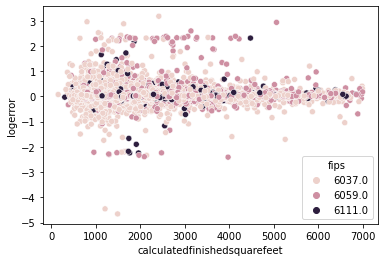

In [41]:
# For a simple visual answer, I'm going to use a scatterplot, with logerror being the value.

sns.scatterplot(x = 'calculatedfinishedsquarefeet', y = 'logerror', data = train, hue = 'fips')

<AxesSubplot:xlabel='latitude', ylabel='logerror'>

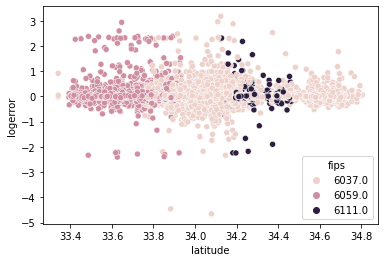

In [42]:
sns.scatterplot(x = 'latitude', y = 'logerror', data = train, hue = 'fips')

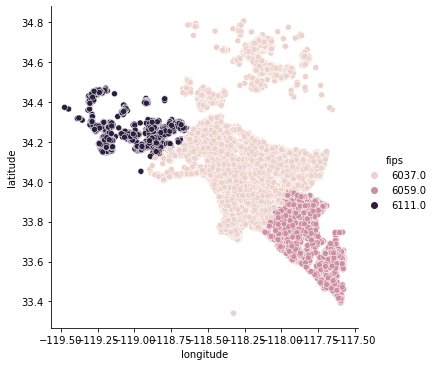

In [43]:
sns.relplot(x="longitude", y="latitude", hue="fips", data=train)

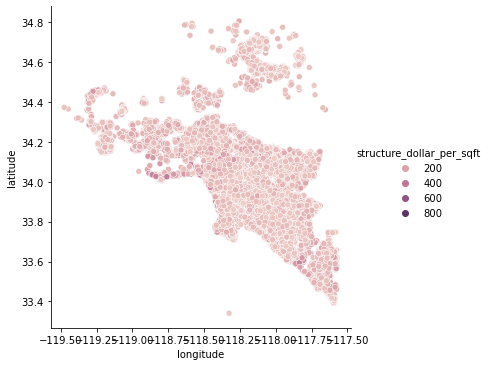

In [44]:
sns.relplot(x="longitude", y="latitude", hue="structure_dollar_per_sqft", data=train)

In [45]:
# Are there any features that I want to create from the existing data? Any I want to take away?
# First let's check the distributions of the existing cleaned columns:

## Can I visualize any significant relationship between logerror and any of my current features?

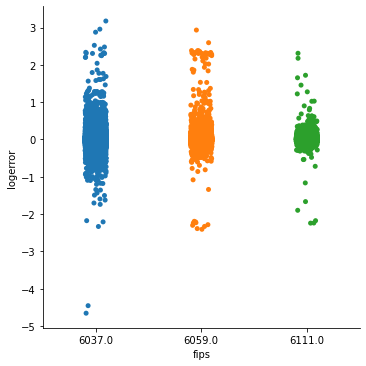

In [46]:
# I'm not seeing any... And if I can't find any, not sure what to test or model on...

sns.catplot(x = 'fips', y = 'logerror', data = train)

In [47]:
# What should I bit? How effective would that be? Let's run histograms to see what the distributions are:

In [48]:
area_vars = ['latitude', 'longitude', 'age']

def elbow_plot(cluster_vars):
    # elbow method to identify good k for us
    ks = range(2,20)
    
    # empty list to hold inertia (sum of squares)
    sse = []

    # loop through each k, fit kmeans, get inertia
    for k in ks:
        kmeans = KMeans(n_clusters=k)
        kmeans.fit(X_train[cluster_vars])
        # inertia
        sse.append(kmeans.inertia_)

    print(pd.DataFrame(dict(k=ks, sse=sse)))

    # plot k with inertia
    plt.plot(ks, sse, 'bx-')
    plt.xlabel('k')
    plt.ylabel('SSE')
    plt.title('Elbow method to find optimal k')
    plt.show()

     k           sse
0    2  5.085732e+06
1    3  2.307681e+06
2    4  1.292371e+06
3    5  8.691218e+05
4    6  6.257359e+05
5    7  4.453102e+05
6    8  3.421522e+05
7    9  2.679179e+05
8   10  2.187538e+05
9   11  1.775396e+05
10  12  1.589282e+05
11  13  1.381108e+05
12  14  1.257433e+05
13  15  1.112756e+05
14  16  1.004354e+05
15  17  9.249958e+04
16  18  8.163796e+04
17  19  7.536556e+04


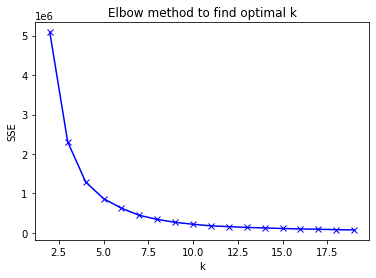

In [49]:
elbow_plot(cluster_vars = area_vars)

In [ ]:
# Based on this is seems like 4-5 centroids is the optimal number of clusters for our data.

### Questions:

- Do I need to bin anything?
- What is the average tax rate per county?
- combine tax amount and square feet by county and compare

In [ ]:
# heatmap_df = train(scale this)

<AxesSubplot:>

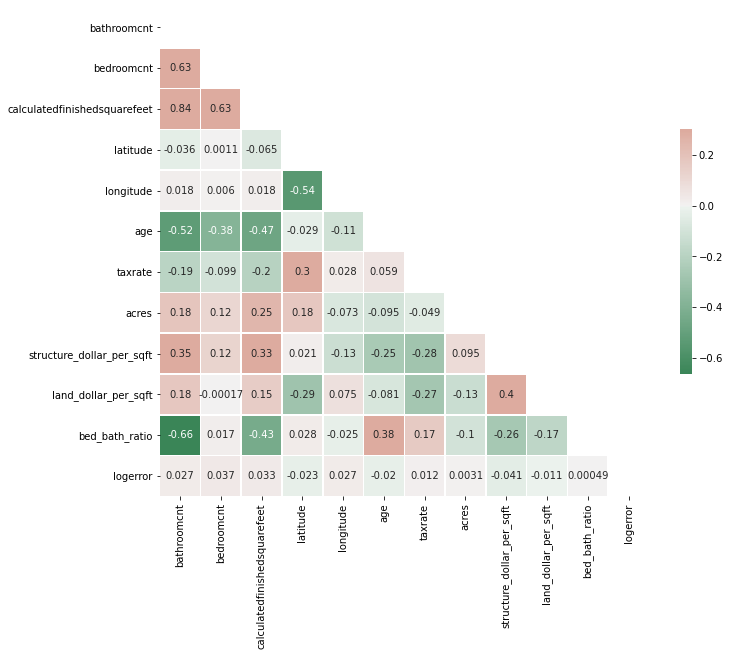

In [50]:
# going to try all columns:

# Creating a dataframe for a more managable heatmap
# corr_eval_df = train[['bathroomcnt', 'bedroomcnt', 'calculatedfinishedsquarefeet', 'fullbathcnt', 'latitude', 'longitude', 'lotsizesquarefeet', 'regionidcity', 'roomcnt', 'yearbuilt', 'structuretaxvaluedollarcnt', 'landtaxvaluedollarcnt', 'taxvaluedollarcnt', 'taxamount', 'age', 'taxrate', 'acres', 'structure_dollar_per_sqft', 'land_dollar_per_sqft', 'bed_bath_ratio', 'county', 'logerror']]
corr_eval_df = train[['bathroomcnt', 'bedroomcnt', 'calculatedfinishedsquarefeet', 'latitude', 'longitude', 'age', 'taxrate', 'acres', 'structure_dollar_per_sqft', 'land_dollar_per_sqft', 'bed_bath_ratio', 'logerror']]

# Code for the heatmap itself:
corr = corr_eval_df.corr()
# Generate a mask for the upper triangle
mask = np.triu(np.ones_like(corr, dtype=bool))
# Set up the matplotlib figure
f, ax = plt.subplots(figsize=(11, 9))
# Generate a custom diverging colormap
cmap = sns.diverging_palette(500, 20, as_cmap=True)
# Draw the heatmap with the mask and correct aspect ratio
sns.heatmap(corr, annot = True, mask=mask, cmap=cmap, vmax=.3, center=0,
            square=True, linewidths=.5, cbar_kws={"shrink": .5})

#### Takeaways:
- Right now the highest correlation is `fullbathcnt` and `age`
- But none of these features actually are over the limit of .2 or -.2 to become remotely "significant"

This correlation matrix usually provides some hints as to which features are statistically correlated to the target variable, ie `logerror` in this case...

Still, I need to take whatever the MOST significant features are and go with those... at least for the MVP

In [ ]:
# So log error is higher in orange county...? Interesting.

# What types of houses are predominant in Orange county? Low priced, high priced, normal "family" priced homes?

# Is the model worse at predicting middle income type homes, and better at the outliers?



# Clustering

In [51]:
from sklearn.cluster import KMeans

In [ ]:

# Fit K-Means
X = X_train_scaled[["age", "structure_dollar_per_sqft"]]
kmeans = KMeans(n_clusters=5)
kmeans.fit(X)

X_train_scaled['cluster'] = kmeans.labels_
X_train_scaled.head()

In [ ]:
# visualize w/ hue="species" style="cluster"
sns.relplot(x="age", y="structure_dollar_per_sqft", hue="fips", col="cluster", data=X_train_scaled)

In [ ]:
X = X_train_scaled[['age', 'land_dollar_per_sqft']]
kmeans = KMeans(n_clusters=4)
kmeans.fit(X)

In [ ]:

# visualize w/ hue="species" style="cluster"
sns.relplot(x="age", y="land_dollar_per_sqft", hue="fips", col="cluster", data=X_train_scaled)

In [ ]:
# visualize w/ hue="species" style="cluster"
sns.relplot(x="LA", y="structure_dollar_per_sqft", hue="fips", col="cluster", data=X_train_scaled)

In [ ]:
def get_inertia(k):
    return KMeans(k).fit(X).inertia_

plt.figure(figsize=(13, 7))

df = pd.Series([get_inertia(k) for k in range(2, 13)]).plot()

plt.xlabel('k')
plt.ylabel('inertia')
plt.xticks(range(2, 13))
plt.grid()

In [ ]:
# It appears that the best number of centroids is around 4-5. So I'll try that again.

In [52]:
# Scale the datasets
scaler = MinMaxScaler()
cols = train.drop(columns=["logerror"]).columns.tolist()

# .copy() makes a proper copy
train_scaled = train.copy()
validate_scaled = validate.copy()
test_scaled = test.copy()

train_scaled[cols] = scaler.fit_transform(train[cols])
validate_scaled[cols] = scaler.transform(validate[cols])
test_scaled[cols] = scaler.transform(test[cols])

In [54]:
# Fit K-Means
X2 = train_scaled[["age", "structure_dollar_per_sqft"]]
kmeans2 = KMeans(n_clusters=5)
kmeans2.fit(X2)

train_scaled['cluster'] = kmeans2.labels_
train_scaled.head()

,bathroomcnt,bedroomcnt,calculatedfinishedsquarefeet,fips,latitude,longitude,lotsizesquarefeet,regionidcity,roomcnt,yearbuilt,structuretaxvaluedollarcnt,taxvaluedollarcnt,landtaxvaluedollarcnt,taxamount,logerror,LA,Orange,Ventura,age,taxrate,acres,structure_dollar_per_sqft,land_dollar_per_sqft,bed_bath_ratio,cluster
65326,0.166667,0.333333,0.239661,0.297297,0.200176,0.959305,0.012560,0.023614,0.5,0.717391,0.037870,0.010774,0.006642,0.009892,0.008833,0.0,1.0,0.0,0.282609,0.202970,0.012560,0.076833,0.018128,0.250000,4
39133,0.000000,0.166667,0.095864,0.000000,0.484663,0.889209,0.014645,0.042021,0.0,0.514493,0.023721,0.006011,0.003478,0.007169,0.034919,1.0,0.0,0.0,0.485507,0.257489,0.014645,0.106822,0.008283,0.357143,1
23583,0.166667,0.500000,0.253251,0.000000,0.905745,0.660922,0.021835,0.005198,0.0,0.840580,0.037749,0.009473,0.005183,0.013076,-0.002291,1.0,0.0,0.0,0.159420,0.303107,0.021835,0.072807,0.008299,0.357143,2
42503,0.333333,0.333333,0.271226,0.297297,0.086061,0.971788,0.025203,0.025955,0.0,0.789855,0.056581,0.030088,0.025611,0.026840,0.019921,0.0,1.0,0.0,0.210145,0.200336,0.025203,0.102424,0.035211,0.142857,4
3688,0.000000,0.333333,0.108724,0.000000,0.857532,0.717279,0.015114,0.093460,0.0,0.550725,0.012851,0.002139,0.000805,0.005045,0.180875,1.0,0.0,0.0,0.449275,0.457056,0.015114,0.052245,0.002007,0.571429,1


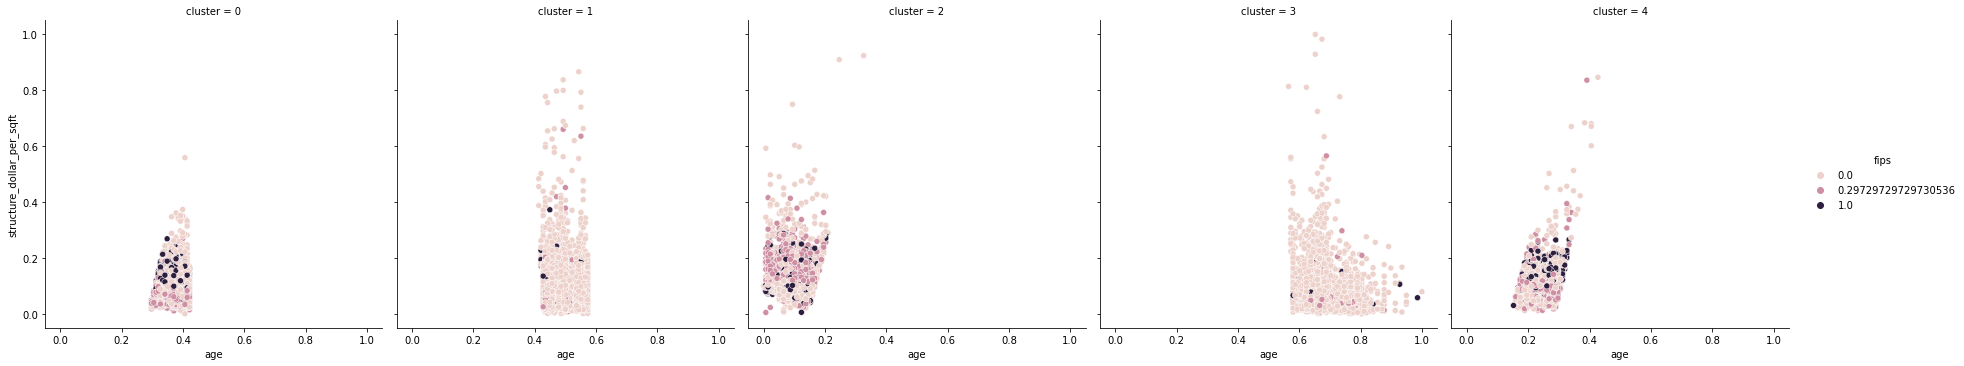

In [55]:
# visualize w/ hue="species" style="cluster"
sns.relplot(x="age", y="structure_dollar_per_sqft", hue="fips", col="cluster", data=train_scaled)

In [56]:
pd.DataFrame(kmeans2.cluster_centers_, columns=X2.columns)

,age,structure_dollar_per_sqft
0,0.370166,0.077088
1,0.477124,0.080977
2,0.105521,0.136846
3,0.674223,0.085557
4,0.240501,0.104498


In [57]:
X2.shape, kmeans2.labels_.shape

((34299, 2), (34299,))

In [60]:
train_scaled['cluster'] = kmeans2.labels_
train_scaled.groupby('cluster').mean()

,bathroomcnt,bedroomcnt,calculatedfinishedsquarefeet,fips,latitude,longitude,lotsizesquarefeet,regionidcity,roomcnt,yearbuilt,structuretaxvaluedollarcnt,taxvaluedollarcnt,landtaxvaluedollarcnt,taxamount,logerror,LA,Orange,Ventura,age,taxrate,acres,structure_dollar_per_sqft,land_dollar_per_sqft,bed_bath_ratio
cluster,,,,,,,,,,,,,,,,,,,,,,,,
0,0.221512,0.423875,0.249090,0.244420,0.428744,0.676438,0.019936,0.067812,0.258279,0.629669,0.040364,0.016336,0.012565,0.017514,0.024457,0.466217,0.411786,0.121997,0.370331,0.254845,0.019936,0.077194,0.029522,0.268518
1,0.142843,0.329527,0.197586,0.056489,0.470841,0.657758,0.018835,0.091257,0.058560,0.522761,0.035479,0.015443,0.012325,0.017259,0.014243,0.861372,0.116891,0.021737,0.477239,0.273405,0.018835,0.080989,0.026809,0.313406
2,0.383998,0.487601,0.400810,0.292702,0.471616,0.698840,0.025564,0.067140,0.112273,0.894279,0.115236,0.034698,0.021535,0.037627,0.020725,0.392491,0.447994,0.159515,0.105721,0.265044,0.025564,0.136782,0.050902,0.196022
3,0.111973,0.293139,0.201161,0.036833,0.468856,0.642753,0.016299,0.079390,0.027149,0.325502,0.039324,0.018911,0.015655,0.020720,0.008123,0.923928,0.055840,0.020232,0.674498,0.269013,0.016299,0.085263,0.039012,0.329219
4,0.275525,0.408237,0.296128,0.259455,0.491438,0.701907,0.027251,0.062759,0.209583,0.759182,0.064704,0.020809,0.013781,0.021831,0.018596,0.473798,0.379602,0.146600,0.240818,0.251678,0.027251,0.104422,0.033258,0.217640


<AxesSubplot:xlabel='structure_dollar_per_sqft', ylabel='age'>

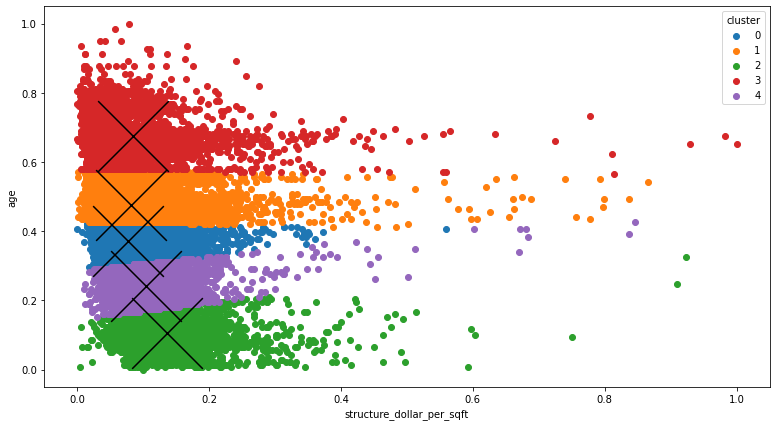

In [61]:
fig, ax = plt.subplots(figsize=(13, 7))

for cluster, subset in train_scaled.groupby('cluster'):
    ax.scatter(subset.structure_dollar_per_sqft, subset.age, label=cluster)
ax.legend(title='cluster')
ax.set(ylabel='age', xlabel='struture value')

train_scaled.groupby('cluster').mean().plot.scatter(y='age', x='structure_dollar_per_sqft', marker='x', s=5000, ax=ax, c='black')

### Hypothesis Test:

##### Features: `age` and `structure_dollar_per_sqft`

$H_0$: The population means for the 5 clusters are all equal (**no** significant difference)

$H_a$: The population means for the 5 clusters are not equal (there **is** a significant difference)

In [62]:
# Running an ANOVA test for all 5 clusters that used the KMeans form of clustering. 
# Recall that for KMeans I have to use scaled data because it is so sensitive to outliers.

alpha = .05

cluster_one = train_scaled[train_scaled.cluster == 0].logerror
cluster_two = train_scaled[train_scaled.cluster == 1].logerror
cluster_three = train_scaled[train_scaled.cluster == 2].logerror
cluster_four = train_scaled[train_scaled.cluster == 3].logerror
cluster_five = train_scaled[train_scaled.cluster == 4].logerror

In [64]:
# The test:

import scipy.stats as stats

f, p = stats.f_oneway(cluster_one, cluster_two, cluster_three, cluster_four, cluster_five)
f, p

(7.413232790280459, 5.7911169612880695e-06)

In [65]:
if p < alpha:
    print("We reject the null hypothesis")
else:
    print("We fail to reject null hypothesis")

We reject the null hypothesis


## Breakthrough:

- It appears as though the `age` and `structure_dollar_per_sqft` independent variables' variance are at least statistically significant.
- Now I'm going to try two more different combinations of features in order to get the MVP done.
- I want to try using DBSCAN in order to see if that does a better job of clustering than KMeans

In [67]:
# Scale the datasets
scaler3 = MinMaxScaler()
cols3 = train.drop(columns=["logerror"]).columns.tolist()

# .copy() makes a proper copy
train_scaled3 = train.copy()
validate_scaled3 = validate.copy()
test_scaled3 = test.copy()

train_scaled3[cols3] = scaler3.fit_transform(train[cols3])
validate_scaled3[cols3] = scaler3.transform(validate[cols3])
test_scaled3[cols3] = scaler3.transform(test[cols3])

In [68]:
# Fit K-Means
X3 = train_scaled3[["latitude", "longitude"]]
kmeans3 = KMeans(n_clusters=4)
kmeans3.fit(X3)

train_scaled3['cluster'] = kmeans3.labels_
train_scaled3.head()

,bathroomcnt,bedroomcnt,calculatedfinishedsquarefeet,fips,latitude,longitude,lotsizesquarefeet,regionidcity,roomcnt,yearbuilt,structuretaxvaluedollarcnt,taxvaluedollarcnt,landtaxvaluedollarcnt,taxamount,logerror,LA,Orange,Ventura,age,taxrate,acres,structure_dollar_per_sqft,land_dollar_per_sqft,bed_bath_ratio,cluster
65326,0.166667,0.333333,0.239661,0.297297,0.200176,0.959305,0.012560,0.023614,0.5,0.717391,0.037870,0.010774,0.006642,0.009892,0.008833,0.0,1.0,0.0,0.282609,0.202970,0.012560,0.076833,0.018128,0.250000,0
39133,0.000000,0.166667,0.095864,0.000000,0.484663,0.889209,0.014645,0.042021,0.0,0.514493,0.023721,0.006011,0.003478,0.007169,0.034919,1.0,0.0,0.0,0.485507,0.257489,0.014645,0.106822,0.008283,0.357143,2
23583,0.166667,0.500000,0.253251,0.000000,0.905745,0.660922,0.021835,0.005198,0.0,0.840580,0.037749,0.009473,0.005183,0.013076,-0.002291,1.0,0.0,0.0,0.159420,0.303107,0.021835,0.072807,0.008299,0.357143,3
42503,0.333333,0.333333,0.271226,0.297297,0.086061,0.971788,0.025203,0.025955,0.0,0.789855,0.056581,0.030088,0.025611,0.026840,0.019921,0.0,1.0,0.0,0.210145,0.200336,0.025203,0.102424,0.035211,0.142857,0
3688,0.000000,0.333333,0.108724,0.000000,0.857532,0.717279,0.015114,0.093460,0.0,0.550725,0.012851,0.002139,0.000805,0.005045,0.180875,1.0,0.0,0.0,0.449275,0.457056,0.015114,0.052245,0.002007,0.571429,3


In [71]:
train_scaled3.cluster.value_counts()

2    15581
0     8167
1     8107
3     2444
Name: cluster, dtype: int64

<AxesSubplot:xlabel='longitude', ylabel='latitude'>

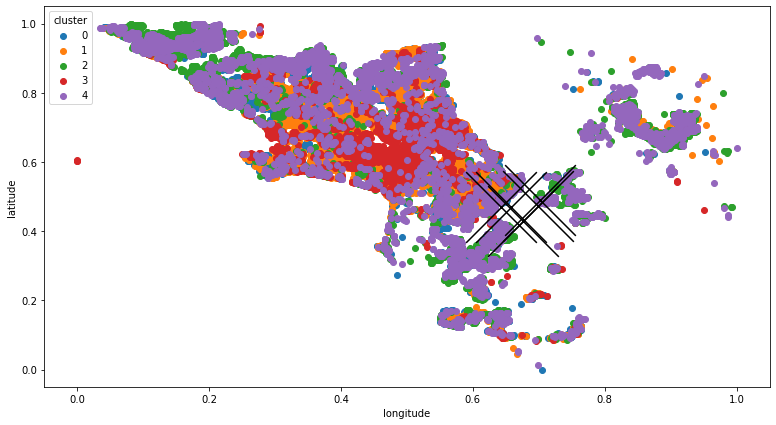

In [72]:
fig, ax = plt.subplots(figsize=(13, 7))

for cluster, subset in train_scaled.groupby('cluster'):
    ax.scatter(subset.latitude, subset.longitude, label=cluster)
ax.legend(title='cluster')
ax.set(ylabel='age', xlabel='struture value')

train_scaled.groupby('cluster').mean().plot.scatter(y='latitude', x='longitude', marker='x', s=5000, ax=ax, c='black')

No use whatever in grouping this way. 

In [ ]:
# Try to find a place where the logerror is particularly high or low. Is it in a specific fips code? Or specific bathroom count? Or specific city ID?

In [ ]:
fig, ax = plt.subplots(figsize=(13, 7))

for cluster, subset in train_scaled.groupby('cluster'):
    ax.scatter(subset.structure_dollar_per_sqft, subset.age, label=cluster)
ax.legend(title='cluster')
ax.set(ylabel='age', xlabel='struture value')

train_scaled.groupby('cluster').mean().plot.scatter(y='age', x='structure_dollar_per_sqft', marker='x', s=5000, ax=ax, c='black')

In [73]:
# Scale the datasets
scaler4 = MinMaxScaler()
cols4 = train.drop(columns=["logerror"]).columns.tolist()

# .copy() makes a proper copy
train_scaled4 = train.copy()
validate_scaled4 = validate.copy()
test_scaled4 = test.copy()

train_scaled4[cols4] = scaler4.fit_transform(train[cols4])
validate_scaled4[cols4] = scaler4.transform(validate[cols4])
test_scaled4[cols4] = scaler4.transform(test[cols4])

In [87]:
# Fit K-Means
X4 = train_scaled4[["bed_bath_ratio", "land_dollar_per_sqft"]]
kmeans4 = KMeans(n_clusters=4)
kmeans4.fit(X4)

train_scaled4['cluster'] = kmeans4.labels_
train_scaled4.head()

,bathroomcnt,bedroomcnt,calculatedfinishedsquarefeet,fips,latitude,longitude,lotsizesquarefeet,regionidcity,roomcnt,yearbuilt,structuretaxvaluedollarcnt,taxvaluedollarcnt,landtaxvaluedollarcnt,taxamount,logerror,LA,Orange,Ventura,age,taxrate,acres,structure_dollar_per_sqft,land_dollar_per_sqft,bed_bath_ratio,cluster
65326,0.166667,0.333333,0.239661,0.297297,0.200176,0.959305,0.012560,0.023614,0.5,0.717391,0.037870,0.010774,0.006642,0.009892,0.008833,0.0,1.0,0.0,0.282609,0.202970,0.012560,0.076833,0.018128,0.250000,2
39133,0.000000,0.166667,0.095864,0.000000,0.484663,0.889209,0.014645,0.042021,0.0,0.514493,0.023721,0.006011,0.003478,0.007169,0.034919,1.0,0.0,0.0,0.485507,0.257489,0.014645,0.106822,0.008283,0.357143,0
23583,0.166667,0.500000,0.253251,0.000000,0.905745,0.660922,0.021835,0.005198,0.0,0.840580,0.037749,0.009473,0.005183,0.013076,-0.002291,1.0,0.0,0.0,0.159420,0.303107,0.021835,0.072807,0.008299,0.357143,0
42503,0.333333,0.333333,0.271226,0.297297,0.086061,0.971788,0.025203,0.025955,0.0,0.789855,0.056581,0.030088,0.025611,0.026840,0.019921,0.0,1.0,0.0,0.210145,0.200336,0.025203,0.102424,0.035211,0.142857,1
3688,0.000000,0.333333,0.108724,0.000000,0.857532,0.717279,0.015114,0.093460,0.0,0.550725,0.012851,0.002139,0.000805,0.005045,0.180875,1.0,0.0,0.0,0.449275,0.457056,0.015114,0.052245,0.002007,0.571429,3


In [88]:
train_scaled4.cluster.value_counts()

2    15203
1     8518
0     7913
3     2665
Name: cluster, dtype: int64

<AxesSubplot:xlabel='land_dollar_per_sqft', ylabel='bed_bath_ratio'>

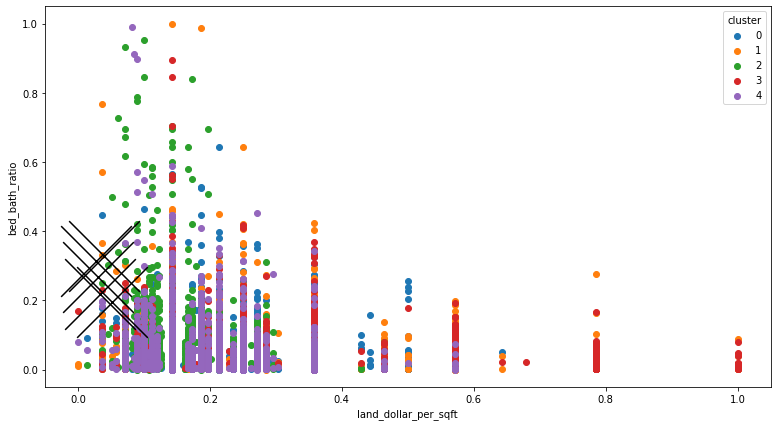

In [90]:
fig, ax = plt.subplots(figsize=(13, 7))

for cluster, subset in train_scaled.groupby('cluster'):
    ax.scatter(subset.bed_bath_ratio, subset.land_dollar_per_sqft, label=cluster)
ax.legend(title='cluster')
ax.set(ylabel='age', xlabel='struture value')

train_scaled.groupby('cluster').mean().plot.scatter(y='bed_bath_ratio', x='land_dollar_per_sqft', marker='x', s=5000, ax=ax, c='black')

In [ ]:
# Fit K-Means
X = X_train_scaled[["latitude", "longitude"]]
kmeans = KMeans(n_clusters=6)
kmeans.fit(X)

X_train_scaled['cluster'] = kmeans.labels_
X_train_scaled.head()

In [ ]:
# visualize w/ hue="species" style="cluster"
sns.relplot(x="longitude", y="latitude", hue="fips", col="cluster", data=X_train_scaled)

#### This is actually a very interesting result 

It seems like the clustering actually did a pretty decent job of clustering by location data... and incidentally, when I ran the correlation matrix, location information was the most correlated than the other features... still not significantly so, but more so than the other features.

In [ ]:
pd.DataFrame(kmeans.cluster_centers_, columns=X.columns)

In [ ]:
# Adding back a county column to the train df in order to viz the counties:
train_viz = train.copy()

In [ ]:
# separating by county

# converting fips code to int. Will need to convert to string if I import into Tableau.
train_viz['fips'] = train_viz['fips'].astype('int')

conditions = [
    (train_viz['fips'] == 6037),
    (train_viz['fips'] == 6059),
    (train_viz['fips'] == 6111)
    ]

county_list = ['Los Angeles', 'Orange', 'Ventura']

train_viz['county'] = np.select(conditions, county_list)
train_viz.shape


In [ ]:
sns.relplot(x="longitude", y="latitude", hue="county", data=train_viz)

In [ ]:
# I'm not able to get any real clusters... so I'm going to try and focus on modeling and finish the MVP
